# Introduction


___

Nama: Dwi Adhi Widigda K.

Batch: FTDS-027

Program ini dibuat untuk menerapkan konsep Computer Vision yang dapat membedakan jamur yang dapat dikosumsi dan yang beracun.


___



# Latar Belakang

___

Jamur sering dikonsumsi untuk nustrisi dan khasiat obat nya. Tetapi untuk membedakan antara jamur yang dapat dikonsumsi dan yang beracun cukup sulit. Seseorang yang salah mengidentifikasi jamur yang beracun sebagai jamur yang bisa dimakan dapat mengakibatkan konsekuensi kesehatan atau kematian.

___

# Problem Statement

___

Problem Statement: Mengidentifikasikan jamur yang dapat dimakan dan yang beracun cukup sulit. Oleh karena itu model ANN yang dapat membedakan jamur yang bisa dimakan dan yang beracun perlu dibuat. Target akurasi dari model yang dibuat lebih besar daripada 90% dengan menggunkan konsep Convolution Neural Network dan pengerjaan model dilakukan selama 7 hari. Model yang dibuat diharapkan dapat mengajari orang untuk mengidentifikasi jamur yang beracun dan yang tidak.

___

# 1. Import Libraries

In [ ]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import tensorflow_addons as tfa

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from sklearn.utils import class_weight
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input,GlobalMaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

Projek ini menggunakan library dari numpy, pandas, seaborn, matplotlib, os, glob, sklearn, dan tensorflow

In [ ]:
tf.__version__

'2.18.0'

# 2. Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Google collab di connect dengan g-drive untuk mengambil folder gambar jamur

In [ ]:
folder_path = '/content/drive/My Drive/mushroom_image'

Tampung path folder gambar jamur ke variable folder_path.

In [ ]:
files = os.listdir(folder_path)
print(files)

['training', 'validation']


In [ ]:
# Define path
#main_path = '/content/shoeTypeClassifierDataset/'
train_path = os.path.join(folder_path, 'training')
test_path = os.path.join(folder_path, 'validation')

train_path dan test_path memiliki path dari folder training dan validation di google drive

In [ ]:
train_path

'/content/drive/My Drive/mushroom_image/training'

In [ ]:
test_path

'/content/drive/My Drive/mushroom_image/validation'

In [ ]:
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - edible mushroom sporocarp : 643
Total Data - poisonous mushroom sporocarp : 774

Test Path
Total Data - poisonous mushroom sporocarp : 86
Total Data - edible mushroom sporocarp : 72



folder gambar jamur dibagi menjadi 2 subfolder, training dan validation.

Di dalam data ini tedapat 2 class yaitu edible mushroom sporocarp atau jamur yang aman dan poisonous mushroom sporocarp atau jamur yang beracun.

Jamur yang aman di folder training sebanyak 643 dan jamur yang beracun sebanyak 774

Jamur yang aman di folder validation sebanyak 72 dan jamur yang beracun sebanyak 86

Perbedaan antara gambar 2 class di sekitar 131 dan 14 bisa dibilang data cukup tidak balance.

# 3. Exploratory Data Analysis (EDA)

In [ ]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  edible mushroom sporocarp


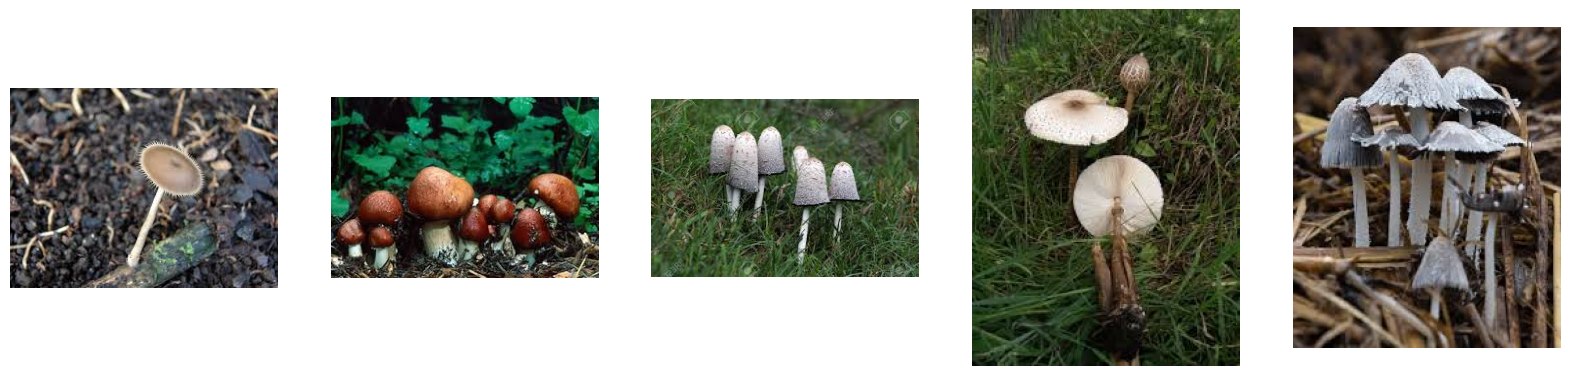

Class :  poisonous mushroom sporocarp


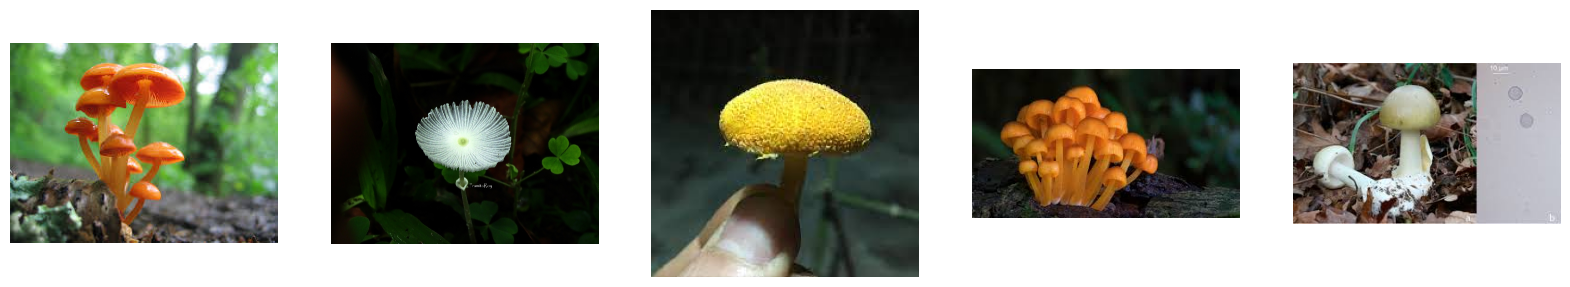

In [ ]:
plot_images(train_path)

Berikut adalah 5 gambar pertama dari class edible mushroom sporocarp dan poisonous mushroom sporocarp di training.

Jamur di class edible mushroom sporocarp berwarna putih atau cokelat dan memiliki cap yang cukup bervariasi.

Jamur di class poisonous mushroom sporocarp lebih berwarna cerah dibandingkan class edible mushroom sporocarp dan memiliki cap yang lebih kecil.



Class :  poisonous mushroom sporocarp


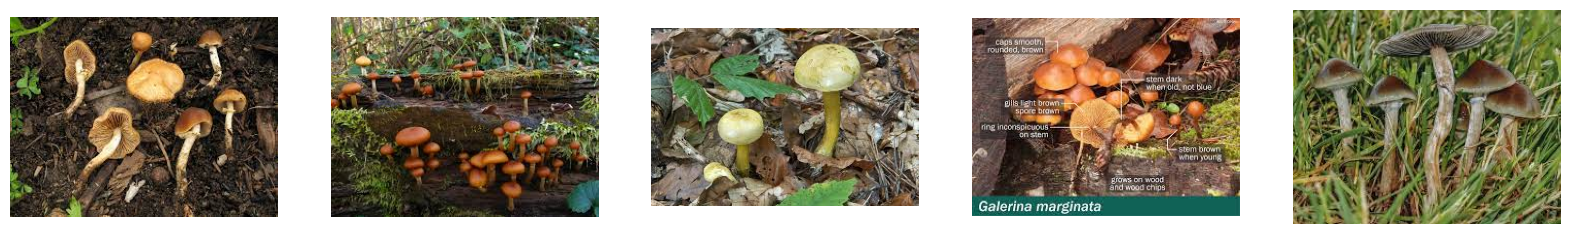

Class :  edible mushroom sporocarp


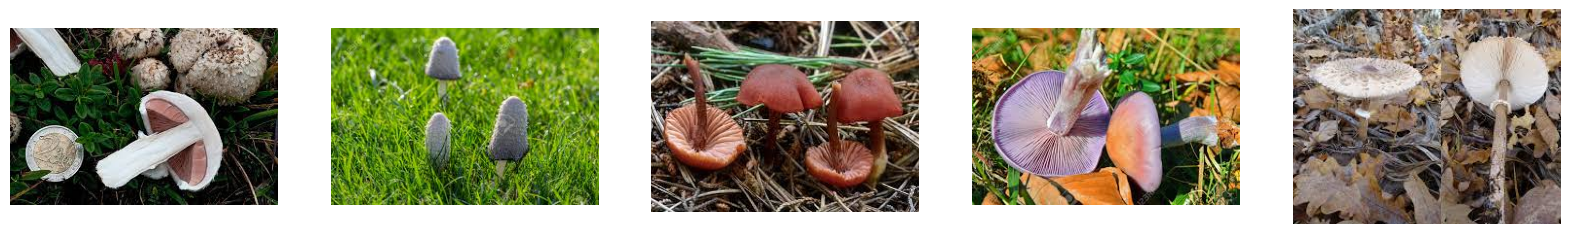

In [ ]:
# Visualization of `test_path`

plot_images(test_path)

Berikut adalah 5 gambar pertama untuk class poisonous mushroom sporocarp dan edible mushroom sporocarp

Gambar di class edible mushroom sporocarp cenderung berwarna putih sedangkan yang beracun lebih berwarna cokelat atau warna terang.

# 4. Feature Engineering

## Set parameter

In [ ]:
img_height = 224
img_width = 224
batch_size = 32
seed = 20

## Data Augment and Split ,Val, Test

Gambar di train_path akan di split menjadi train_ds, val_ds, dan test_ds dengan parameter img_size 224 x 224 pixel, batch size 32 dan seed 20.

In [ ]:
# Create batch generator for train-set, val-set, and test-set

# Data Augment
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                horizontal_flip=True,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='binary',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=seed)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=seed)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=seed)

Found 851 images belonging to 2 classes.
Found 566 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


Data augment terhadapat gambar jamur berupa horizonal flip dan validation di split dengan ratio 60:40.

Data di split menjadi train_set, val_set yang akan digunakan dalam training dan test_set yang digunakan untuk prediksi.

Selain itu train_set, val_set, dan test_set juga di scaling dengan cara dibagi dengan 255.

test_ds diambil dari test_path

In [ ]:
train_set.class_indices

{'edible mushroom sporocarp': 0, 'poisonous mushroom sporocarp': 1}

Class edible mushroom sporocarp direpresentasikan dengan angka 0 dn poisonous mushroom sporocarp dengan angka 1

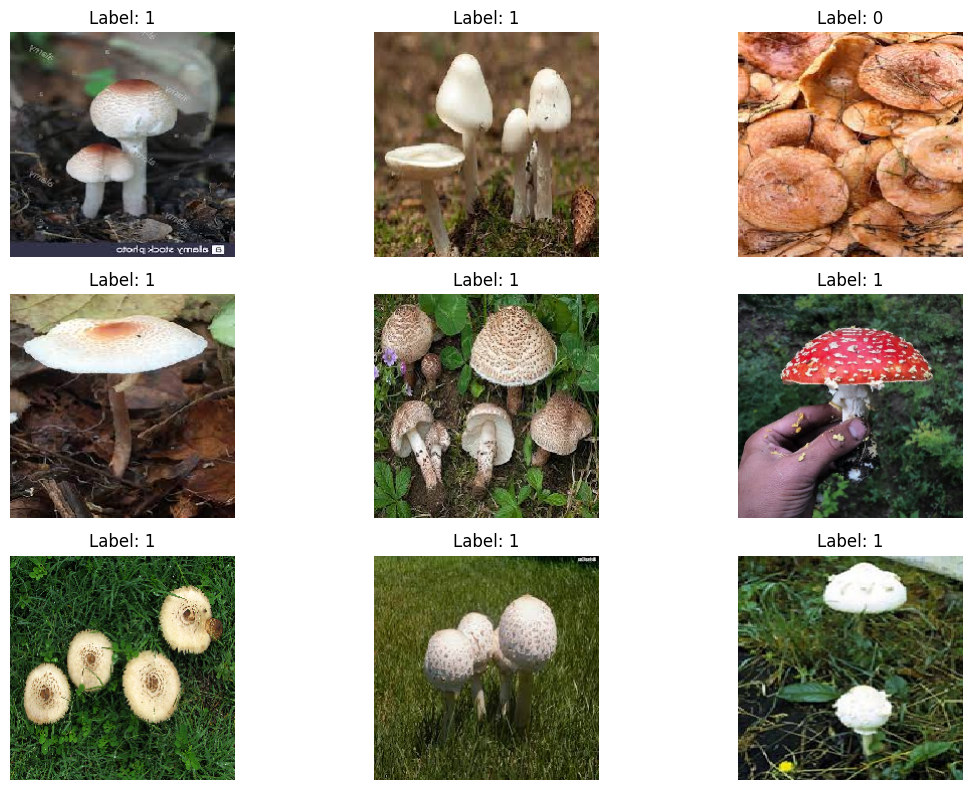

In [ ]:
images, labels = next(train_set)


num_images = 9
plt.figure(figsize=(12, 8))

for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Berikut adalah gambar jamur setelah di augment. Di gambat pojok kanan atas, gambar jamur memiliki caption yang di putar horizontal.

# 5. ANN Training

## Model Definition

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_seq = Sequential()

# input layer
model_seq.add(Input(shape=(224, 224, 3))) # shape = jumlah fiturnya. Cocokin sama yang di Train set
# hidden layer 1
model_seq.add(Conv2D(32, (3, 3), activation='relu'))
model_seq.add(MaxPooling2D())
# hidden layer 2
model_seq.add(Conv2D(16, (3, 3), activation='relu'))
model_seq.add(MaxPooling2D())
#flatten
model_seq.add(Flatten())
# hidden layer 3
model_seq.add(Dense(8, activation='relu'))
# output layer
model_seq.add(Dense(1, activation='sigmoid'))
model_seq.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',Recall()]
)
model_seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       373,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,785 (1.44 MB)

 Trainable params: 378,785 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Berikut adalah base model

Model ini sequential dengan 3 bagian yaitu input layer, hidden layer, dan outer layer.

Input layer terdiri dari 1 node yang menerima input

Hidden layer terdiri dari 3 bagian yaitu hidden layer 1, hidden layer 2 dan hidden layer 3.

Hidden layer 1 memiliki 32 node dengan activation function relu yang melakukan convulution (3,3) terhadap pixel di gambar. Pixel akan di MaxPooling

Hidden layer 1 memiliki 16 node dengan activation function relu yang melakukan convulution (3,3) terhadap pixel di gambar. Pixel akan di MaxPooling

Berikut nya input akan di flatten untuk merubah gambar menjadi tensor

Hidden layer 3 hanya memiliki 8 node dengan activation function relu

Output layer memiliki 1 node dengan activation function sigmoid karena hasil data binary.

Model di compile dengan optimizer adam, mengghitung loss dengan cara binary crossentropy dan mengukur metrik evaluasi akurasi (default) dan Recall(). Recall digunakan untuk meminimalisir False Negative di prediksi yaitu prediksi nya jamur edible tetapi actual nya jamur beracun.



## Model Training

In [ ]:
mushroom = model_seq.fit(train_set, epochs=25, validation_data=val_set, batch_size=batch_size)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.5179 - loss: 0.7977 - recall: 0.3624 - val_accuracy: 0.5919 - val_loss: 0.6855 - val_recall: 0.6634
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - accuracy: 0.6704 - loss: 0.6483 - recall: 0.7284 - val_accuracy: 0.5883 - val_loss: 0.6696 - val_recall: 0.4854
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.7062 - loss: 0.5806 - recall: 0.7250 - val_accuracy: 0.6166 - val_loss: 0.6708 - val_recall: 0.9094
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.7327 - loss: 0.5393 - recall: 0.7562 - val_accuracy: 0.5919 - val_loss: 0.7153 - val_recall: 0.9838
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.7615 - loss: 0.4967 - recall: 0.8397 - val_accuracy: 0.6272 - val_loss: 0.6759 - val_recall: 0.6667
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.7858 - loss: 0.4602 - recall: 0.8377 - val_accuracy: 0.5972 - val_loss: 0.7396 - val_recall: 0.4887

Model di train dengan epoch sebanyak 25

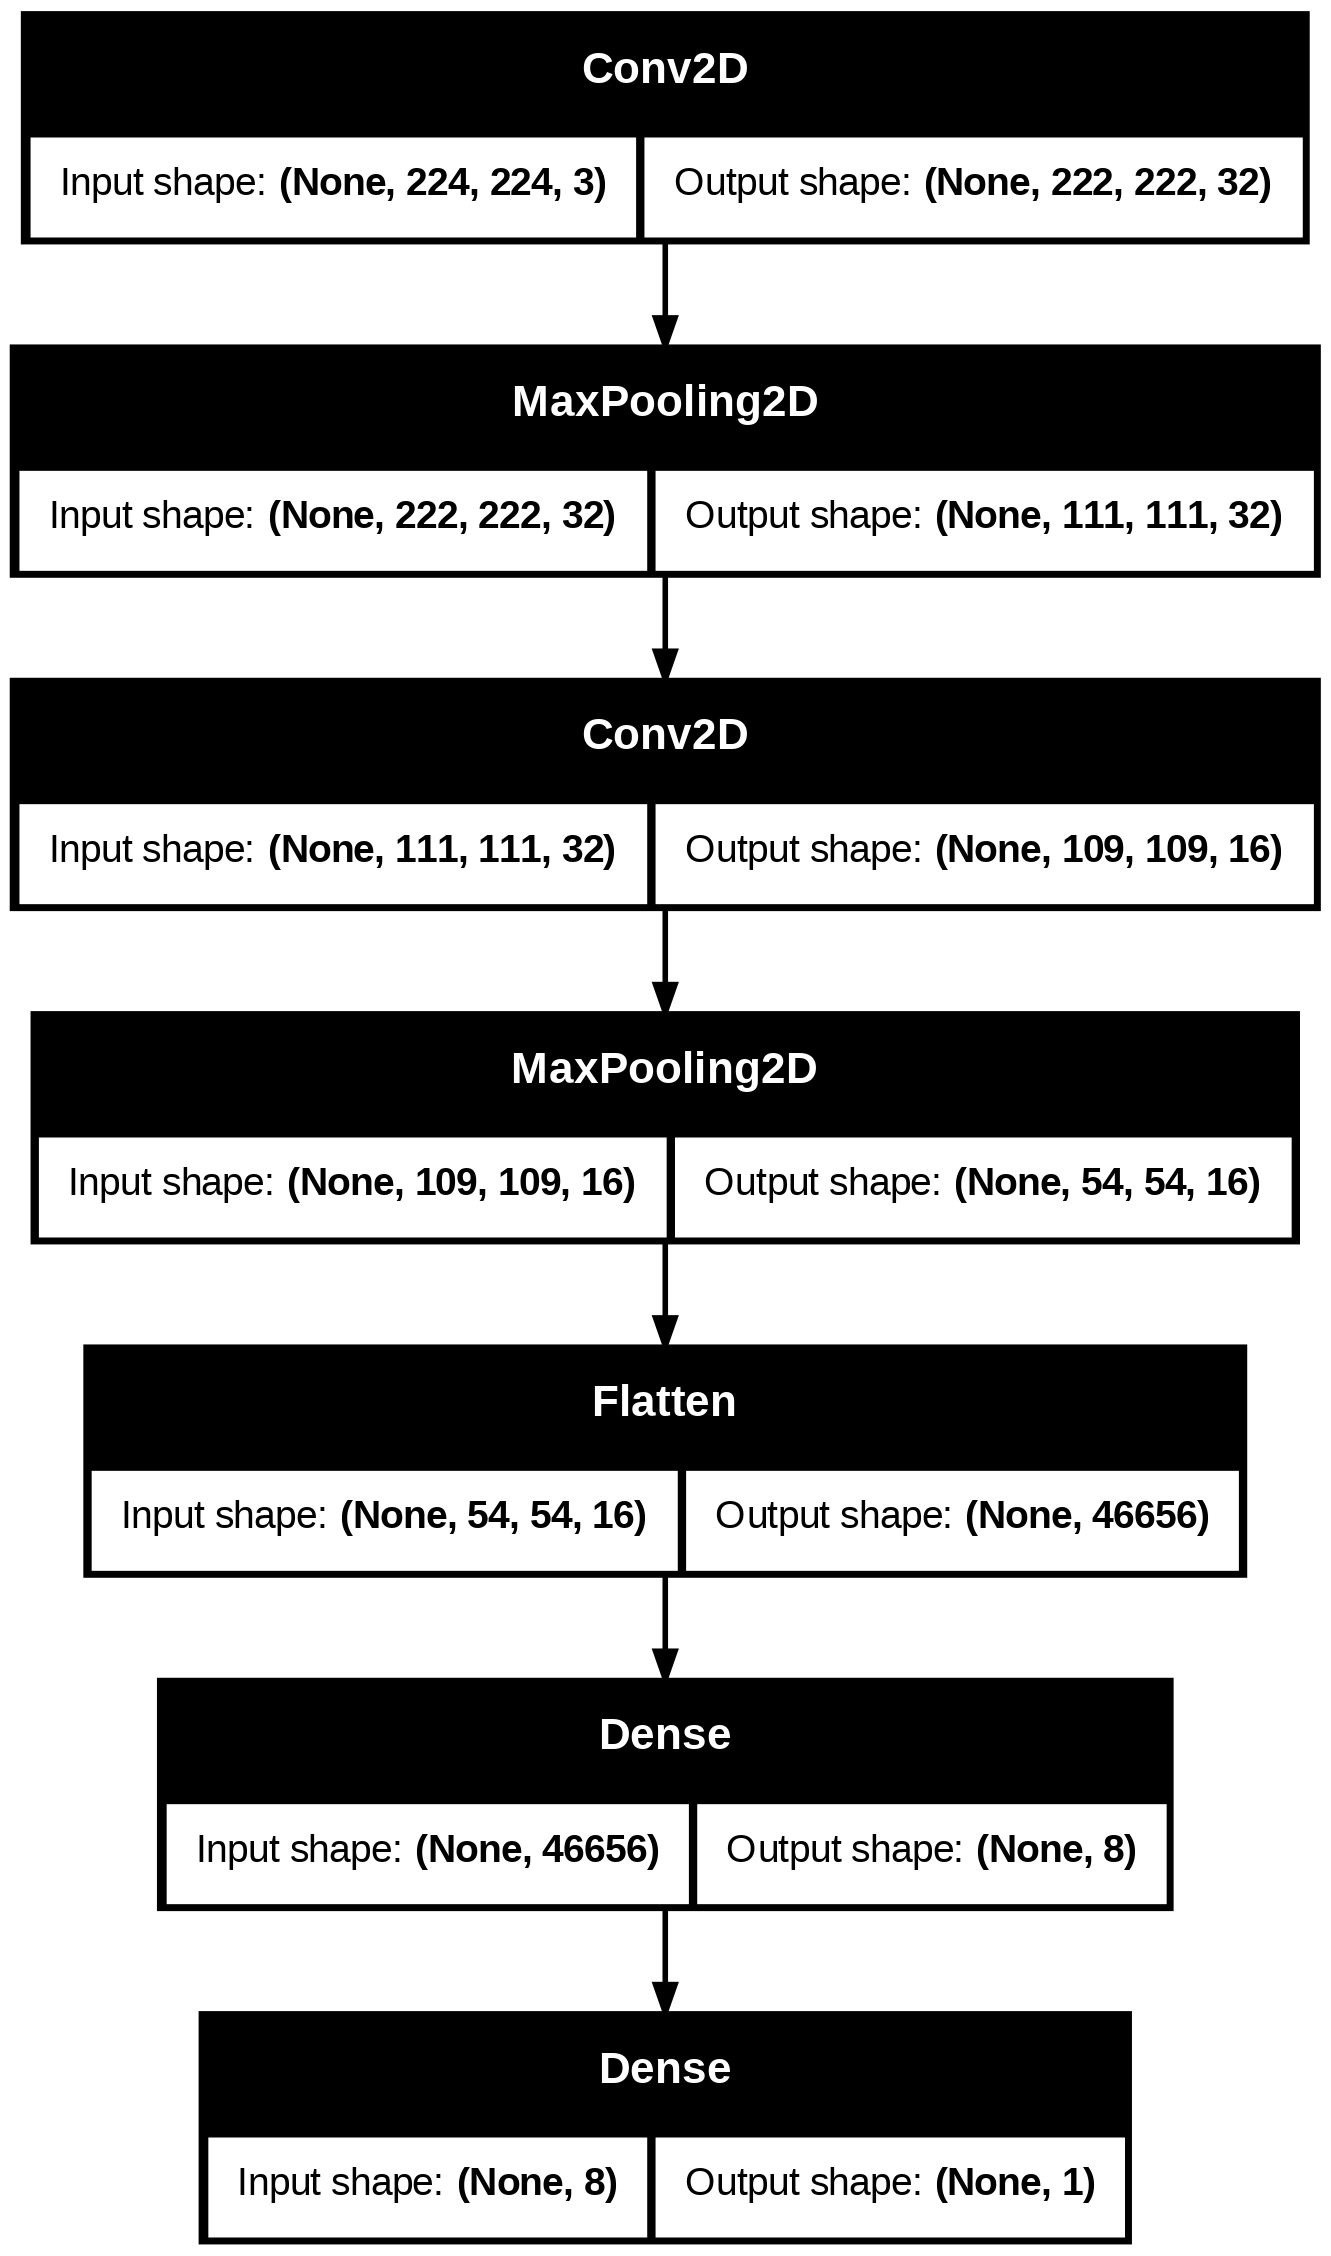

In [ ]:
tf.keras.utils.plot_model(model_seq, show_shapes=True)

Berikut arsitektur base model

## Model Evaluation

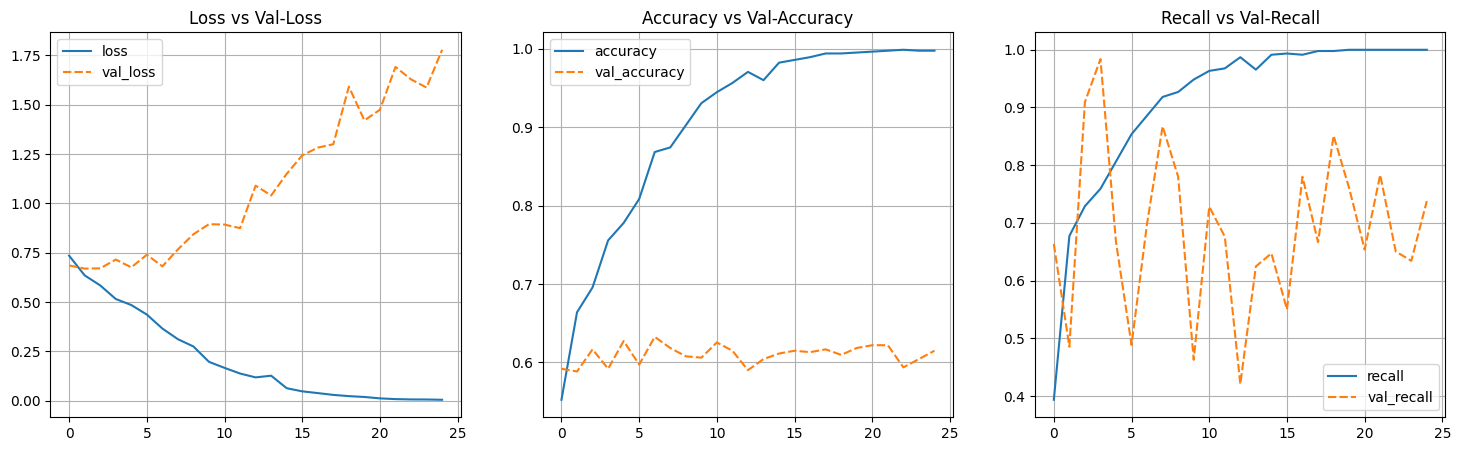

In [ ]:
# Plot training results

mushroom_df = pd.DataFrame(mushroom.history)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=mushroom_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 3, 2)
sns.lineplot(data=mushroom_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 3, 3)
sns.lineplot(data=mushroom_df[['recall', 'val_recall']])
plt.grid()
plt.title('Recall vs Val-Recall')

plt.show()

Berikut hasil loss, accuracy dan recall dalam linegraph. Di linegraph loss vs val-loss, dalam 20 epoch loss turun hingga mendekati 0 tetapi val-loss nye naik.

Di linegraph recall vs val-recall, recall naik dan berbentuk kurva dimana nilai recall mencapai 1 di epoch 20 tetapi val-recall berbentuk flaktuasi dan berada di range sekitar 0.6 hingga 0.75 setelah epoch 20.

Bisa dibilang model masih underfit karena tidak ada irisan antara garis train dan validation.

In [ ]:
y_true = test_set.classes

# Predicted probabilities
y_pred_prob = model_seq.predict(test_set)

# Convert probabilities to class labels (binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Get class names in the correct order
class_names = list(test_set.class_indices.keys())

# Generate and print the report
print(classification_report(y_true, y_pred, target_names=class_names))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
                              precision    recall  f1-score   support

   edible mushroom sporocarp       0.54      0.57      0.55        72
poisonous mushroom sporocarp       0.62      0.59      0.61        86

                    accuracy                           0.58       158
                   macro avg       0.58      0.58      0.58       158
                weighted avg       0.58      0.58      0.58       158



In [ ]:
y_true = train_set.classes

# Predicted probabilities
y_pred_prob = model_seq.predict(train_set)

# Convert probabilities to class labels (binary classification)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Get class names in the correct order
class_names = list(train_set.class_indices.keys())

# Generate and print the report
print(classification_report(y_true, y_pred, target_names=class_names))

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step
                              precision    recall  f1-score   support

   edible mushroom sporocarp       0.46      0.45      0.45       386
poisonous mushroom sporocarp       0.55      0.55      0.55       465

                    accuracy                           0.51       851
                   macro avg       0.50      0.50      0.50       851
                weighted avg       0.51      0.51      0.51       851



Untuk classification report saya mengunkan recall untuk yang beracun dan precision untuk yang bisa dimakan untuk menimalisir false negative(prediksi nya aman tapi aktual beracun) dan false positive(prediksi nya beracun tapi aktual aman)

Di classification report nilai untuk train set edible mushroom sporocarp 0.45 dan di test set 0.57

Nilai train set poisonous mushroom sporocarp 0.55 dan di test set 0.59

Nilai recall dan precision cukup rendah dan bisa dibilang model ANN menghasilkan nilai underfit dan tidak bisa mengidentifikasi jamur yang aman dikonsumsi dan yang beracun. Untuk tahap berikut nya perlu dilakukan model improvement agar tidak underfit.

# ANN Improvement With Balancing

## Data Augment

In [ ]:
# Create batch generator for train-set, val-set, and test-set

# Data Augment
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                horizontal_flip=True,
                                                                rotation_range=40,
                                                                height_shift_range = 0.2,
                                                                width_shift_range = 0.2,
                                                                validation_split=0.2)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='binary',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=seed)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=seed)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=seed)

Found 1135 images belonging to 2 classes.
Found 282 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


Saya menambah height_shift_range dan width_shift_range sebesar 20% yang akan membesarkan tingga dan lebar.
dan validation_split untuk ratio 80:20 dan rotation_range untuk memutar gambar secara acak dengan sudut dengan range -40 sampai 40 derajat. Gambar juga di split dengan ratio 80:20.

In [ ]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

Function ini adalah function binary_focal_loss seperti binary cross entropy tetapi untuk data yang imbalanced. Gamma adalah mengatur agar model tidak terlalu bekerja di contoh yang mudah dan alpha untuk fokus kepada jamur beracun (1)

In [ ]:
steps_per_epoch = np.ceil(1417 / batch_size).astype(int)

steps_per_epoch adalah berapa banyak langah setiap epoch yang diambil dari total data training / dengan batch_size

## Model Definition

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
class_weights = {0: 3.0, 1: 1.0} # untuk mengatur data imbalance nya

model_improvement_EN = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_improvement_EN.trainable = True

x = model_improvement_EN.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)

predictions = Dense(1, activation='sigmoid',kernel_initializer='glorot_normal')(x)

model_E31 = Model(inputs=model_improvement_EN.input, outputs=predictions)
model_E31.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=binary_focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy',Recall()]
)
model_E31.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,382,884 (16.72 MB)

 Trainable params: 4,338,301 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

Berikut adalah arsitektur dari model improvement dengan balancing.

Model improvement menggunakan model functional dengan transfer learning EfficientNetB0 untuk 1 input layer,

1 hidden layer dengan node 256 dan relu activation function dan

1 output layer dengan loss dari function binary_focal_loss, optimizer Adam dengan learning rate 0.000001 dan kernel_initializer glorot_normal.

## Model Training

In [ ]:
mushroom_31 = model_E31.fit(train_set, epochs=25, validation_data=val_set,class_weight=class_weights, steps_per_epoch=steps_per_epoch)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5138 - loss: 0.3865 - recall: 0.6281 - val_accuracy: 0.5461 - val_loss: 0.0892 - val_recall: 0.8896
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 616ms/step - accuracy: 0.5007 - loss: 0.3593 - recall: 0.6330 - val_accuracy: 0.5461 - val_loss: 0.0740 - val_recall: 1.0000
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 568ms/step - accuracy: 0.5644 - loss: 0.3138 - recall: 0.7126 - val_accuracy: 0.5461 - val_loss: 0.0783 - val_recall: 1.0000
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 563ms/step - accuracy: 0.5801 - loss: 0.2893 - recall: 0.7258 - val_accuracy: 0.5461 - val_loss: 0.0773 - val_recall: 1.0000
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.5917 - loss: 0.2504 - recall: 0.7416 - val_accuracy: 0.5496 - val_loss: 0.0751 - val_recall: 1.0000
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 567ms/step - accuracy: 0.6245 - loss: 0.2232 - recall: 0.8018 - val_accuracy: 0.5426 - val_loss: 0.0738 - val_recall: 0.9870


Training model menggunakan class_weight dan steps_per_epoch

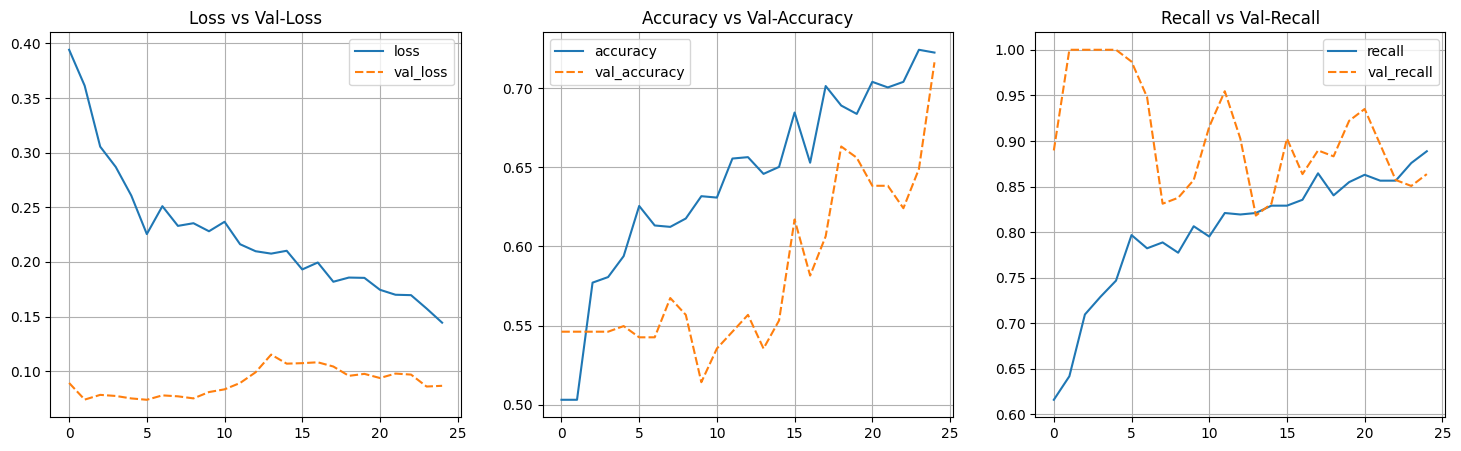

In [ ]:
# Plot training results

mushroom_31_df = pd.DataFrame(mushroom_31.history)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=mushroom_31_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 3, 2)
sns.lineplot(data=mushroom_31_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 3, 3)
sns.lineplot(data=mushroom_31_df[['recall', 'val_recall']])
plt.grid()
plt.title('Recall vs Val-Recall')

plt.show()

Berikut adalah linegraph dari loss, accuracy, dan recall.

Linegraph loss menunjukan penurunan hingga mencapai nilai 0.15 saat epoch 25 untuk loss dan val_loss nya cukup stabul dengan nilai epoch sekitar 0.08. Loss dari data kucup kecil.

Linegraph Recall menunjukan penaikan hingga mencapai nilai sekitar 0.87 di epoch 25 dan val_recall mengalami penurunan hingga mencapai nilai sekitar 0.85. Perbedaan recall dan val_recall cukup kecil bisa dibilang model dapat mengidentifikasi jamur beracun.

In [ ]:
y_true = test_set.classes

# Predicted probabilities
y_pred_prob = model_E31.predict(test_set)

# Convert probabilities to class labels (binary classification)
y_pred = (y_pred_prob > 0.2).astype("int32").flatten()

# Get class names in the correct order
class_names = list(test_set.class_indices.keys())

# Generate and print the report
print(classification_report(y_true, y_pred, target_names=class_names))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
                              precision    recall  f1-score   support

   edible mushroom sporocarp       0.85      0.15      0.26        72
poisonous mushroom sporocarp       0.58      0.98      0.73        86

                    accuracy                           0.60       158
                   macro avg       0.71      0.56      0.49       158
                weighted avg       0.70      0.60      0.51       158



In [ ]:
y_true = train_set.classes

# Predicted probabilities
y_pred_prob = model_E31.predict(train_set)

# Convert probabilities to class labels (binary classification)
y_pred = (y_pred_prob > 0.2).astype("int32").flatten()

# Get class names in the correct order
class_names = list(train_set.class_indices.keys())

# Generate and print the report
print(classification_report(y_true, y_pred, target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step
                              precision    recall  f1-score   support

   edible mushroom sporocarp       0.43      0.08      0.13       515
poisonous mushroom sporocarp       0.54      0.92      0.68       620

                    accuracy                           0.54      1135
                   macro avg       0.49      0.50      0.41      1135
                weighted avg       0.49      0.54      0.43      1135



Di classification report nilai untuk train set edible mushroom sporocarp 0.45 dan di test set 0.57

Nilai train set poisonous mushroom sporocarp 0.55 dan di test set 0.59

Nilai recall dan precision cukup rendah kelas cukup rendah dan bisa dibilang model ANN menghasilkan nilai underfit. Untuk tahap berikut nya perlu dilakukan model improvement agar tidak underfit.

Berikut adalah classification report model improvement. Setelah di improve nilai precision edible mushroom sporocarp adalah 0.43 untuk train_set dan 0.85 untuk test_set.

Nilai recall poisonous mushroom sporocarp sebesar 0.92 di train_set dan 0.98 di test_set.

Setelah model improvement nilai untuk poisonous mushroom sporocarp meningkat dimana model dapat mengidentifikasikan jamur yang beracun tetapi model tidak dapat mengidentifikasi jamur yang aman karena hasil model overfit.

# 7. Model Saving

In [ ]:
model_E31.save('model_E31.keras')

Saving model_E31 dengan cara .keras

# 8. Model Inferences

In [ ]:
def import_and_predict(image_data, model):
    target_size = (224, 224)  # Set the target size to match the model's input shape
    image = load_img(image_data, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, 0)  # Create a batch

    # Normalize the image
    img_array = img_array / 255.0

    # Make prediction
    predictions = model.predict(img_array)

    # Get the class with the highest probability
    predicted_class = np.where(predictions > 0.2, 1, 0)[0][0]


    class_names = ['edible mushroom sporocarp', 'poisonous mushroom sporocarp']

    result = f"Prediction: {class_names[predicted_class]}"

    return result

In [ ]:
import_and_predict('/content/drive/My Drive/mushroom_inference/enoki.jpg',model_E31)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


'Prediction: poisonous mushroom sporocarp'

Model memprediksi jamur enoki sebagai jamur beracun yang sebenarnya jamur tersebut aman dimanakan

In [ ]:
import_and_predict('/content/drive/My Drive/mushroom_inference/amanita.jpg',model_E31)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


'Prediction: poisonous mushroom sporocarp'

Model dapat memprediksi jamur amanita sebagai jamur yang beracun.

# Kesimpulan
- Convolutional Neural Network dapat diterapakan dalam kasus Computer Vision ini
- Model Artificial Neural Nerwork yang dibuat dapat mengidentifikasi jamur yang beracun setelah dilakukan model improvement dengan nilai recal 0.98 di test dan 0.92 di train melebihi nilai yang di rencanakan (90).
- Tetapi model tidak dapat mengidentifikasi jamur yang aman dikonsumsi. Bisa jadi fitur yang ada di jamur beracun dan yang tidak beracun mirip sehingga model sulit membedakan nya.
-Improvement dalam model ini adalah memperbanyak gambar jamur yang aman dikonsumsi lebih banyak dari pada jamur yang beracun agar model dapat dapat membedakan kedua class.